In [6]:
from pathlib import Path
import sys
sys.path.insert(0, "../")
from ukbfound.tokenizer.traitg_tokenizer import ValueVocab
from ukbfound.model import TransformerModel
import pandas as pd
import json
import ukbfound
logger = ukbfound.logger
import torch
import numpy as np
from torch import nn


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [7]:
data_dir = Path("../data/UKB")
data_df = pd.read_csv(data_dir / "output_data.csv", index_col=0)


# ---
# 查找影响copd分亚型的关键 Traits

In [21]:
# 查找影响copd分亚型的关键 Traits

from anndata import AnnData
import scanpy as sc
from scanpy.get import _get_obs_rep, _set_obs_rep
import shutil
from scipy.sparse import issparse
from sklearn.model_selection import train_test_split
from ukbfound.tokenizer import tokenize_and_pad_batch, random_mask_value
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict, Union, Optional
import os

#model_dir = Path("save/all_data_dev_UKB-Jul11-17-11")
# 加载模型和词库
#model_dir = Path("save/dev_UKB-Aug20-22-27") #dev_UKB-Aug07-18-18 只提取20002，随机15%20002疾病 mask训练；  dev_UKB-Aug08-21-38 随机15%20002疾病 mask训练；  dev_UKB-Aug11-22-41 随机5%mask训练； dev_UKB-Aug20-22-27
model_dir = Path("save/dev_UKB-Sep10-00-11") 
model_config_file = model_dir / "config.json"
model_file = model_dir / "model.pt"
vocab_file = model_dir / "vocab.json"

pad_token = "<pad>"
mask_token = "<mask>"
cls_token = "<cls>"
vocab = ValueVocab.from_file(vocab_file)



traits_df = pd.read_csv(data_dir / 'ukb_traits.csv', encoding='latin1', quotechar='"')
# 创建一个字典，其中 token_id 是键，token_id 是值
token_dict = dict(zip(traits_df['token_id'], traits_df['token_id']))
#  vacab need start with 0 index
token_dict['<cls>'] = 0  # 和其他模式统一， 用0
token_dict['<mask>'] = len(token_dict)
token_dict['<pad>'] = len(token_dict)

# 将values字典保存成 JSON 文件
with open(data_dir / "vocab.json", 'w') as f:
    json.dump(token_dict, f, indent=4)

vocab_file = data_dir / "vocab.json"
vocab = ValueVocab.from_file(vocab_file)
shutil.copy(vocab_file, "values_vocab.json")
vocab.set_default_index(vocab["<pad>"])
# change adata value to combine 'col_value' style
data_df_copd = data_df_copd.fillna(vocab["<pad>"])
adata = sc.AnnData(data_df_copd.values)

traitg_dict = {v:i for i, v in  enumerate(traits_df['trait'].unique(), 1)}

value2traitg_dict = {}
for value_id in traits_df['token_id']:
    value2traitg_dict[value_id] = traitg_dict[traits_df.loc[traits_df['token_id'] == value_id, 'trait'].iat[0]]
value2traitg_dict.update({token_dict['<cls>']:0})
value2traitg_dict.update({token_dict['<mask>']:max(value2traitg_dict.values())+1})
value2traitg_dict.update({token_dict['<pad>']:max(value2traitg_dict.values())+1})
# 创建一个向量化的函数，用于字典查找
vectorized_replace = np.vectorize(value2traitg_dict.get)

# 获取特殊字符value
mask_value = vocab[mask_token]
pad_value = vocab[pad_token]
cls_value = vocab[cls_token]

# 使用该函数对 all_counts 进行替换，并覆盖原数组
trait_ids = vectorized_replace(adata.X)


input_layer_key = None

individualtypes_labels = data_df_copd.index

train_data = adata.X

max_seq_len = 3000
mask_ratio = 0.15
tokenized_train = tokenize_and_pad_batch(
    train_data,
    trait_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=False,  # append <cls> token at the beginning
    include_zero_trait=True,
)

logger.info(
    f"train set number of samples: {tokenized_train['traits'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['traits'].shape[1]}"
)


input_trait_ids_train = tokenized_train["traits"]
target_values_train = tokenized_train["values"]





/tmp/ipykernel_744495/1961232502.py:29: DtypeWarning: Columns (6,21,38) have mixed types. Specify dtype option on import or set low_memory=False.
  traits_df = pd.read_csv(data_dir / 'ukb_traits.csv', encoding='latin1', quotechar='"')


scGPT - INFO - train set number of samples: 1665, 
	 feature length: 2874


In [1244]:
## 循环排除对F1值没有影响的traits，缩减重要的traits. 从69个中再进一步筛选
import copy
important_traits = important_traits_69
important_traits.remove('c1003_t20002-1112_i2_v22_s2_e6')
important_traits.append('c1003_t20002-1112_i2_v22_s2_e6')
important_traits_origin = copy.deepcopy(important_traits)
useless_traits = []
last_trait = important_traits[-1]
for trait in important_traits_origin:
    print('trait', trait)
    print('last_trait=', last_trait)
    if trait == last_trait:
        print('jump out')
        break
    important_traits.remove(trait)
    excluded_value_tokens = traits_df[~traits_df['trait'].isin(important_traits)]['token_id'].values
    
    # 假设 tokenized_train["values"] 是一个整数类型的张量
    input_values_train = tokenized_train["values"].clone()
    
    # 确保 diseases_df 的值转换为与 input_values_train 相同的类型
    excluded_value_tokens_tensor = torch.tensor(excluded_value_tokens, dtype=input_values_train.dtype)
    
    # 掩码值也要与 input_values_train 保持相同的数据类型
    pad_value_tensor = torch.tensor(pad_value, dtype=input_values_train.dtype)
    
    # 使用 torch.isin 和 torch.where 进行掩码操作
    input_values_train = torch.where(
        torch.isin(input_values_train, excluded_value_tokens_tensor),
        pad_value_tensor,
        input_values_train
    )
    
    
    
    
    tensor_batch_labels_train = torch.zeros(input_trait_ids_train.shape[0])
    tensor_individualtype_labels_train = individualtypes_labels
    
    
    train_data_pt = {
        "trait_ids": input_trait_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
        "individualtype_labels": tensor_individualtype_labels_train,
    }
    
    # dataset
    class SeqDataset(Dataset):
        def __init__(self, data: Dict[str, torch.Tensor]):
            self.data = data
    
        def __len__(self):
            return self.data["trait_ids"].shape[0]
    
        def __getitem__(self, idx):
            return {k: v[idx] for k, v in self.data.items()}
    
    
    num_workers = len(os.sched_getaffinity(0))
    
    dataset = SeqDataset(train_data_pt)
    
    
    train_loader = DataLoader(
        dataset=dataset,
        batch_size=100,
        shuffle=False,  # 20240905改成False避免后续提取eid混乱
        drop_last=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    
    
    
    
    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["layer_size"]
    nhead = model_configs["nhead"]
    d_hid = model_configs["layer_size"]
    nlayers = model_configs["nlayers"]
    
    
    dropout = model_configs["dropout"]
    mask_value = vocab[mask_token]
    pad_value = vocab[pad_token]
    cls_value = vocab[cls_token]
    MVC = False
    DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
    INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier
    
    num_batch_types = 1
    DSBN = False,  # Domain-spec batchnorm
    input_emb_style = "combine"  # "category" or "continuous" or "scaling" or "combine"
    n_input_bins = None
    individual_emb_style = "avg-pool"  # "avg-pool" or "w-pool" or "cls"
    mvc_decoder_style = "inner product"
    
    ecs_threshold = model_configs["ecs_thres"]
    explicit_zero_prob = True
    fast_transformer = True
    fast_transformer_backend = "flash"
    pre_norm=False
    CLS = False
    
    ntokens = len(set(value2trait_dict.values()))  # size of vocabulary
    model = TransformerModel(
        ntokens,
        embsize,
        nhead,
        d_hid,
        nlayers,
        nlayers_cls=3,
        n_cls=num_types if CLS else 1,
        vocab=vocab,
        dropout=dropout,
        pad_token=pad_token,
        do_mvc=MVC,
        do_dab=DAB,
        use_batch_labels=INPUT_BATCH_LABELS,
        num_batch_labels=num_batch_types,
        domain_spec_batchnorm=DSBN,
        input_emb_style=input_emb_style,
        n_input_bins=n_input_bins,
        individual_emb_style=individual_emb_style,
        mvc_decoder_style=mvc_decoder_style,
        ecs_threshold=ecs_threshold,
        explicit_zero_prob=explicit_zero_prob,
        use_fast_transformer=fast_transformer,
        fast_transformer_backend=fast_transformer_backend,
        pre_norm=pre_norm,
    )
    
    # 加载模型参数
    state_dict = torch.load(model_file)
    
    # 去除所有键的 module. 前缀
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith('module.'):
            new_key = key[len('module.'):]  # 去除 module. 前缀
        else:
            new_key = key
        new_state_dict[new_key] = value
    
    # 使用新的 state_dict 加载模型
    model.load_state_dict(new_state_dict)
    
    logger.info(f"Loading all model params from {model_file}")
    model.eval()
    
    model.to('cuda:0')
    select_disease_embeddings_list = []
    for batch, batch_data in enumerate(train_loader):
        input_trait_ids = batch_data["trait_ids"].to('cuda:0')
        input_values = batch_data["values"].to('cuda:0')
        target_values = batch_data["target_values"].to('cuda:0')
        batch_labels = batch_data["batch_labels"].to('cuda:0')
        individualtype_labels = batch_data["individualtype_labels"].to('cuda:0')
        src_key_padding_mask = input_trait_ids.eq(vocab[pad_token])
        with torch.no_grad():
            transformer_output = model._encode(
                input_trait_ids, input_values, src_key_padding_mask, batch_labels
            )
            
            # 只选出每个样本有copd的embedding
            select_disease_embeddings_list.append(transformer_output[input_values == 1508].cpu()) # 移动到CPU以释放GPU显存
        
            # 删除不再需要的变量以释放显存
            del transformer_output, input_trait_ids, input_values, target_values, batch_labels, individualtype_labels, src_key_padding_mask
            
            torch.cuda.empty_cache()
    
    # 将所有在CPU上的张量重新移动到GPU上
    select_disease_embeddings = torch.cat(select_disease_embeddings_list, dim=0).to('cpu')
    
    
    # 提取所有的token和对应的embedding向量
    embeddings = select_disease_embeddings.detach().to('cpu').numpy()
    
    # 使用 leiden 聚类，UMAP进行降维
    umap_model = umap.UMAP(n_components=2, random_state=42)  # 降维到2维
    embedding_2d = umap_model.fit_transform(embeddings)  # (1000, 2)
    # 构建 K-近邻图并使用 Leiden 进行聚类
    adata = sc.AnnData(embeddings)
    sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')
    sc.tl.leiden(adata, resolution=0.15)
    
    # 获取聚类结果
    labels = adata.obs['leiden'].astype(int).values
    
    
    from sklearn.metrics import confusion_matrix, f1_score
    f1 = f1_score(traits100_labels, labels, average='weighted')
    print(f1)
    if f1 == 1:
        print('find useless trait=', trait)
        useless_traits.append(trait)
    else:
        important_traits.append(trait)
        

trait c1002_t120_i2_v21_s1_e100258
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1002_t120_i2_v21_s1_e100258
trait c1003_t135_i2_v11_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


0.0
trait c1003_t20001-1004_i2_v22_s2_e3
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20001-1004_i2_v22_s2_e3
trait c1003_t20001-1050_i2_v22_s2_e3
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20001-1050_i2_v22_s2_e3
trait c1003_t20001-1052_i2_v22_s2_e3
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20001-1052_i2_v22_s2_e3
trait c1003_t20001-1062_i2_v22_s2_e3
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20001-1062_i2_v22_s2_e3
trait c1003_t20001-1063_i2_v22_s2_e3
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20001-1063_i2_v22_s2_e3
trait c1003_t20001-1073_i2_v22_s2_e3
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20001-1073_i2_v22_s2_e3
trait c1003_t20001-1080_i2_v22_s2_e3
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20001-1080_i2_v22_s2_e3
trait c1003_t20001-1081_i2_v22_s2_e3
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20001-1081_i2_v22_s2_e3
trait c1003_t20002-1078_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1078_i2_v22_s2_e6
trait c1003_t20002-1237_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1237_i2_v22_s2_e6
trait c1003_t20002-1239_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1239_i2_v22_s2_e6
trait c1003_t20002-1259_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1259_i2_v22_s2_e6
trait c1003_t20002-1353_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1353_i2_v22_s2_e6
trait c1003_t20002-1442_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1442_i2_v22_s2_e6
trait c1003_t20002-1453_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1453_i2_v22_s2_e6
trait c1003_t20002-1459_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1459_i2_v22_s2_e6
trait c1003_t20002-1464_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1464_i2_v22_s2_e6
trait c1003_t20002-1465_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1465_i2_v22_s2_e6
trait c1003_t20002-1577_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1577_i2_v22_s2_e6
trait c1003_t20002-1587_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1587_i2_v22_s2_e6
trait c1003_t20002-1608_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1608_i2_v22_s2_e6
trait c1003_t20002-1636_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1636_i2_v22_s2_e6
trait c1003_t20002-1646_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20002-1646_i2_v22_s2_e6
trait c1003_t20003_i2_v22_s1_e4
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


0.0
trait c1003_t20004_i2_v22_s2_e5
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t20004_i2_v22_s2_e5
trait c1003_t20008_i2_v31_s1_e13
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


0.0
trait c1003_t4836_i2_v21_s1_e100637
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


0.9660126013665868
trait c1003_t6152_i2_v22_s1_e100610
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1003_t6152_i2_v22_s1_e100610
trait c1004_t1468_i2_v21_s1_e100393
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1004_t1468_i2_v21_s1_e100393
trait c1004_t1478_i2_v21_s1_e100394
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1004_t1478_i2_v21_s1_e100394
trait c1004_t1538_i2_v21_s1_e100400
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1004_t1538_i2_v21_s1_e100400
trait c1004_t6144_i2_v22_s1_e100385
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1004_t6144_i2_v22_s1_e100385
trait c1005_t20023_i2_v11_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1005_t20023_i2_v11_s1_e0
trait c1006_t21002_i2_v31_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1006_t21002_i2_v31_s1_e0
trait c1006_t23109_i2_v31_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1006_t23109_i2_v31_s1_e0
trait c1006_t50_i2_v31_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1006_t50_i2_v31_s1_e0
trait c1017_t22025_i0_v31_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1017_t22025_i0_v31_s1_e0
trait c1017_t22028_i0_v21_s1_e100264
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1017_t22028_i0_v21_s1_e100264
trait c1017_t22030_i0_v21_s1_e100264
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1017_t22030_i0_v21_s1_e100264
trait c1018_t20510_i0_v21_s1_e504
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1018_t20510_i0_v21_s1_e504
trait c1018_t20539_i0_v21_s1_e519
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1018_t20539_i0_v21_s1_e519
trait c1018_t2060_i2_v21_s1_e100484
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1018_t2060_i2_v21_s1_e100484
trait c1018_t2100_i2_v21_s1_e100349
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1018_t2100_i2_v21_s1_e100349
trait c1018_t4570_i2_v21_s1_e100478
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1018_t4570_i2_v21_s1_e100478
trait c1018_t4653_i2_v21_s1_e100349
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1018_t4653_i2_v21_s1_e100349
trait c1018_t6145_i2_v22_s1_e100502
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c1018_t6145_i2_v22_s1_e100502
trait c701_t21022_i0_v11_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c701_t21022_i0_v11_s1_e0
trait c701_t26411_i0_v31_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c701_t26411_i0_v31_s1_e0
trait c701_t26414_i0_v31_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c701_t26414_i0_v31_s1_e0
trait c701_t26415_i0_v31_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c701_t26415_i0_v31_s1_e0
trait c701_t6146_i2_v22_s1_e100510
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c701_t6146_i2_v22_s1_e100510
trait c704_t1031_i2_v21_s1_e100327
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c704_t1031_i2_v21_s1_e100327
trait c704_t1060_i2_v11_s1_e100329
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c704_t1060_i2_v11_s1_e100329
trait c704_t1110_i2_v21_s1_e100335
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c704_t1110_i2_v21_s1_e100335
trait c704_t1130_i2_v21_s1_e100337
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c704_t1130_i2_v21_s1_e100337
trait c704_t1628_i2_v21_s1_e100417
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c704_t1628_i2_v21_s1_e100417
trait c704_t22038_i2_v31_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c704_t22038_i2_v31_s1_e0
trait c704_t2624_i2_v21_s1_e100317
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c704_t2624_i2_v21_s1_e100317
trait c704_t2907_i2_v21_s1_e100349
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c704_t2907_i2_v21_s1_e100349
trait c704_t3446_i2_v21_s1_e100351
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c704_t3446_i2_v21_s1_e100351
trait c704_t5364_i2_v11_s1_e100291
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c704_t5364_i2_v11_s1_e100291
trait c705_t1873_i2_v11_s1_e100291
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c705_t1873_i2_v11_s1_e100291
trait c717_t30080_i2_v31_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c717_t30080_i2_v31_s1_e0
trait c717_t30180_i2_v31_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


1.0
find useless trait= c717_t30180_i2_v31_s1_e0
trait c717_t30270_i2_v31_s1_e0
last_trait= c1003_t20002-1112_i2_v22_s2_e6
scGPT - INFO - Resume model from save/dev_UKB-Aug20-22-27/model.pt, the model args will override the config save/dev_UKB-Aug20-22-27/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Aug20-22-27/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


0.0
trait c1003_t20002-1112_i2_v22_s2_e6
last_trait= c1003_t20002-1112_i2_v22_s2_e6
jump out


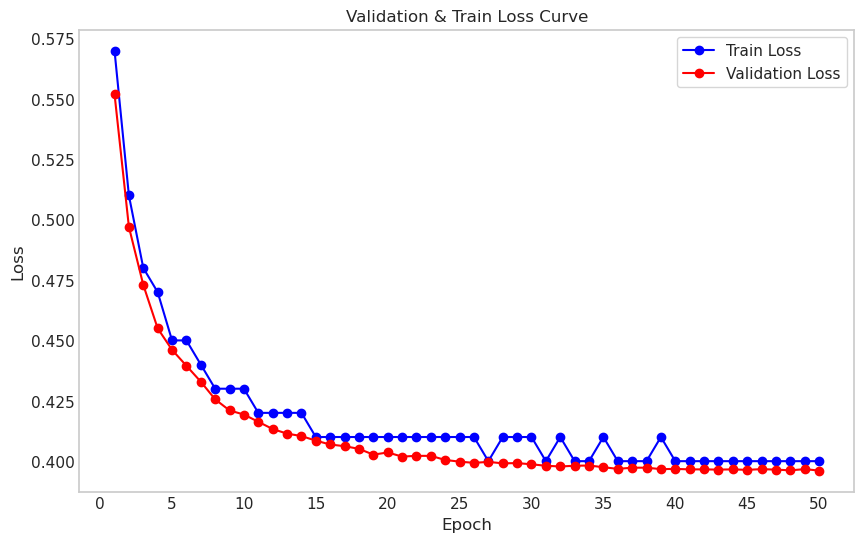

In [407]:
# Fig2.D 损失曲线
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = 'Fig1.D.trait_train_combine.csv'
data = pd.read_csv(file_path)

# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(data['Epoch'], data['Train'], marker='o', linestyle='-', color='blue', label='Train Loss')
plt.plot(data['Epoch'], data['Valid'], marker='o', linestyle='-', color='red', label='Validation Loss')

# Adding title and labels
plt.title('Validation & Train Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adding ticks on both axes
plt.xticks(np.arange(0, 51, step=5))
plt.yticks(np.arange(0.4, 0.6, step=0.025))

# Enabling the grid for better visibility
plt.grid(False)

# Make the ticks more visible by increasing their size and width
plt.tick_params(axis='both', which='major', direction='in', length=8, width=2)

# Saving the figure
plt.savefig('Fig1.D.trait_train_combine.svg')

# Display the plot
plt.show()


scGPT - INFO - Resume model from save/dev_UKB-Sep10-00-11/model.pt, the model args will override the config save/dev_UKB-Sep10-00-11/config.json.
scGPT - INFO - Loading all model params from save/dev_UKB-Sep10-00-11/model.pt


/data/hongqy/dev/ukbGPT/tutorials/../scgpt/model/model.py:76: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


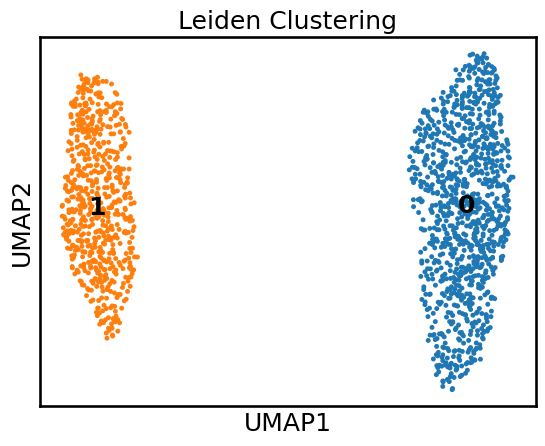

In [52]:
# 不要删20241202 分析COPD， 获取两个大类的样本eid

input_trait_ids_train = tokenized_train["traits"].clone()
input_values_train = tokenized_train["values"].clone()
target_values_train = tokenized_train["values"].clone()
tensor_batch_labels_train = torch.zeros(input_trait_ids_train.shape[0])
tensor_individualtype_labels_train = individualtypes_labels


train_data_pt = {
    "trait_ids": input_trait_ids_train,
    "values": input_values_train,
    "target_values": target_values_train,
    "batch_labels": tensor_batch_labels_train,
    "individualtype_labels": tensor_individualtype_labels_train,
}

# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["trait_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


num_workers = len(os.sched_getaffinity(0))

dataset = SeqDataset(train_data_pt)

train_loader = DataLoader(
    dataset=dataset,
    batch_size=100,
    shuffle=False,  # 20240905改成False避免后续提取eid混乱
    drop_last=False,
    num_workers=num_workers,
    pin_memory=True,
)



# model
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
logger.info(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["layer_size"]
nhead = model_configs["nhead"]
d_hid = model_configs["layer_size"]
nlayers = model_configs["nlayers"]


dropout = model_configs["dropout"]
mask_value = vocab[mask_token]
pad_value = vocab[pad_token]
cls_value = vocab[cls_token]
MVC = False
DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier

num_batch_types = 1
DSBN = False,  # Domain-spec batchnorm
input_emb_style = "combine"  # "category" or "continuous" or "scaling" or "combine"
n_input_bins = None
individual_emb_style = "avg-pool"  # "avg-pool" or "w-pool" or "cls"
mvc_decoder_style = "inner product"

ecs_threshold = model_configs["ecs_thres"]
explicit_zero_prob = True
fast_transformer = True
fast_transformer_backend = "flash"
pre_norm=False
CLS = False

ntokens = len(set(value2trait_dict.values()))  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=3,
    n_cls=num_types if CLS else 1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    do_mvc=MVC,
    do_dab=DAB,
    use_batch_labels=INPUT_BATCH_LABELS,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=DSBN,
    input_emb_style=input_emb_style,
    n_input_bins=n_input_bins,
    individual_emb_style=individual_emb_style,
    mvc_decoder_style=mvc_decoder_style,
    ecs_threshold=ecs_threshold,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=fast_transformer,
    fast_transformer_backend=fast_transformer_backend,
    pre_norm=pre_norm,
)

# 加载模型参数
state_dict = torch.load(model_file)

# 去除所有键的 module. 前缀
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith('module.'):
        new_key = key[len('module.'):]  # 去除 module. 前缀
    else:
        new_key = key
    new_state_dict[new_key] = value

# 使用新的 state_dict 加载模型
model.load_state_dict(new_state_dict)

logger.info(f"Loading all model params from {model_file}")
model.eval()
device = 'cuda:0'
model.to(device)
select_disease_embeddings_list = []
select_eid_list = []
for batch, batch_data in enumerate(train_loader):
    input_trait_ids = batch_data["trait_ids"].to(device)
    input_values = batch_data["values"].to(device)
    target_values = batch_data["target_values"].to(device)
    batch_labels = batch_data["batch_labels"]
    individualtype_labels = batch_data["individualtype_labels"]
    src_key_padding_mask = input_trait_ids.eq(vocab[pad_token])
    with torch.no_grad():
        transformer_output = model._encode(
            input_trait_ids, input_values, src_key_padding_mask, batch_labels
        )
        
        # 只选出每个样本有copd的embedding
        select_disease_embeddings_list.append(transformer_output[input_values == 1508].cpu()) # 移动到CPU以释放GPU显存
        select_eid_list.append(individualtype_labels)
        # 删除不再需要的变量以释放显存
        del transformer_output, input_trait_ids, input_values, target_values, batch_labels, individualtype_labels, src_key_padding_mask
        
        torch.cuda.empty_cache()

# 将所有在CPU上的张量重新移动到GPU上
select_disease_embeddings = torch.cat(select_disease_embeddings_list, dim=0).to('cpu')
select_eids = np.concatenate(select_eid_list)

# 提取所有的token和对应的embedding向量
embeddings = select_disease_embeddings.detach().to('cpu').numpy()


# 构建 K-近邻图并使用 Leiden 进行聚类
adata = sc.AnnData(embeddings)
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')
sc.tl.leiden(adata, resolution=0.15)

# 获取聚类结果
labels = adata.obs['leiden'].astype(int).values
labels = np.where(labels == 0, 'C2', 'C1')
# 运行 UMAP 降维（也可以用 t-SNE）
sc.tl.umap(adata)

# 绘制 UMAP 图，标注 Leiden 聚类结果
sc.pl.umap(adata, color='leiden', title="Leiden Clustering", legend_loc='on data', size=50)
# 保存聚类的类别和EID的对应关系
pd.DataFrame(zip(select_eids, labels), columns=['eid', 'cluster']).to_csv('APP1.Fig2.E.copd_death.20241202.csv')


In [92]:
# 20250131 勿删。 用卡方检验分别计算categories， trait， token的pvalue。 算两个分类和所有类别的p值
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact

# 拼接UMAP 2d embedding和values， 还有eid
embedding_2d_df = pd.DataFrame(embedding_2d, index=range(embedding_2d.shape[0]), columns=['umap1', 'umap2'])
value_tensor_list = []
for batch_data in train_loader:
    # 直接收集每个批次的张量
    value_tensor_list.append(batch_data["values"].detach().to('cpu'))

# 将所有张量沿第一个维度拼接，然后转换为 DataFrame
values_df = pd.DataFrame(torch.cat(value_tensor_list).numpy())

# 直接按列拼接 embedding_2d_df 和 values_df
embedding_2d_values_df = pd.concat([embedding_2d_df, values_df], axis=1)
embedding_2d_values_df.index = data_df_copd.index
embedding_2d_values_df['cluster'] = labels

# 将 DataFrame 按 umap1 分为两个 DataFrame
df_greater_than_5 = embedding_2d_values_df[embedding_2d_values_df['cluster'] == 'C2']
df_less_equal_5 = embedding_2d_values_df[embedding_2d_values_df['cluster'] == 'C1']

# 计算行数比例
#scale_factor = len(df_less_equal_5) / len(df_greater_than_5)

# 将 umap1 和 umap2 列去除，因为不需要比较这些列
df_greater_than_5_values = df_greater_than_5.drop(columns=['umap1', 'umap2', 'cluster'])
df_less_equal_5_values = df_less_equal_5.drop(columns=['umap1', 'umap2', 'cluster'])

# 统计每个具体值的频率，并按比例缩放较多行数的频率
greater_value_counts = df_greater_than_5_values.stack().value_counts()
less_value_counts = df_less_equal_5_values.stack().value_counts()
total_ukb_counts = data_df.stack().value_counts()
# 创建一个包含所有值的 DataFrame，并将频率为 NaN 的值填充为 0
all_values = pd.DataFrame({
    'greater_than_5_freq': greater_value_counts,
    'less_equal_5_freq': less_value_counts,
    'total_ukb_counts': total_ukb_counts,
}).fillna(0)


# 对 greater_than_5_freq 和 less_equal_5_freq 进行T检验
#t_stat, p_value = ttest_ind(all_values['greater_than_5_freq'], all_values['less_equal_5_freq'], equal_var=False)


# 计算两个 DataFrame 中每个值的频率差异
all_values['freq_diff'] = (all_values['greater_than_5_freq'] - all_values['less_equal_5_freq']).abs()


# 输出 p 值
#print(f"T检验的 p 值: {p_value}")

# 按照频率差异的绝对值排序
all_values_sorted = all_values.sort_values(by='freq_diff', ascending=False)

print("频率差异最大的值：")
print(all_values_sorted.head(10))  # 打印差异最大的前10个值




# 划分categories， 并计算每个trait的pvalue
all_values_sorted_rename = all_values_sorted.reset_index().rename(columns={'index': 'token_id'})

# 确保 traits_df 中只包含需要的列
traits_subset = traits_df[['field_id', 'value', 'token_id', 'token', 'trait', 'title', 'category_id', 'category_name']]

# 使用 merge 方法进行左连接
merged_df = pd.merge(all_values_sorted_rename, traits_subset, on='token_id', how='left')

# 将 NaN 值替换为空字符串
#merged_df['token'] = merged_df['token'].fillna('')
merged_df.dropna(inplace=True)



# 使用 Fisher 精确检验替代卡方检验
def calculate_chi2_token(group):
    chi2_values = []
    p_values = []
    p1_values = []
    p2_values = []

    odds_ratios = []
    
    
    for index, row in group.iterrows():
        c1_true = row['greater_than_5_freq']
        c1_false = group['greater_than_5_freq'].sum() - c1_true
    
        c2_true = row['less_equal_5_freq']
        c2_false = group['less_equal_5_freq'].sum() - c2_true

        total_ukb_true =  row['total_ukb_counts']
        total_ukb_false = group['total_ukb_counts'].sum() - total_ukb_true
        
        # 创建一个2x2的列联表
        contingency_table = [
            [c1_true, c2_true],
            [c1_false, c2_false]
        ]
        contingency_table1 = [
            [c1_true, total_ukb_true],
            [c1_false, total_ukb_false]
        ]
        contingency_table2 = [
            [total_ukb_true, c2_true],
            [total_ukb_false, c2_false]
        ]
        
        # 检查期望频数
        if (np.array(contingency_table) == 0).any():
            expected = 0
        else:
            chi2, p_value, _, expected = chi2_contingency(contingency_table)
            _, p_value_c1, _, _ = chi2_contingency(contingency_table1)
            _, p_value_c2, _, _ = chi2_contingency(contingency_table2)
        # 如果期望频数中有任何一个单元格 ≤ 5，则使用 Fisher 精确检验
        if (np.array(expected) <= 5).any():
            odds_ratio, p_value = fisher_exact(contingency_table)
            odds_ratio, p_value_c1 = fisher_exact(contingency_table1)
            odds_ratio, p_value_c2 = fisher_exact(contingency_table2)
            chi2 = None  # Fisher 精确检验不返回 chi2 值
        else:
            odds_ratio = (c1_true * c2_false) / (c1_false * c2_true)  # 计算odds ratio

        
        chi2_values.append(chi2)
        p_values.append(p_value)
        p1_values.append(p_value_c1)
        p2_values.append(p_value_c2)
        odds_ratios.append(odds_ratio)
    group['chi2_token'] = chi2_values
    group['p_value_token'] = p_values
    group['p_value_token_c1'] = p1_values
    group['p_value_token_c2'] = p2_values
    group['odds_ratio_token'] = odds_ratios
    return group[['token_id', 'chi2_token', 'p_value_token','p_value_token_c1', 'p_value_token_c2', 'odds_ratio_token']]

# 根据 token 分组并计算 chi2, p_value 和 odds_ratio
chi2_results_token = merged_df.groupby('trait', group_keys=False)[['trait', 'token_id', 'greater_than_5_freq', 'less_equal_5_freq', 'total_ukb_counts']].apply(calculate_chi2_token)
merged_df = merged_df.merge(chi2_results_token, on='token_id', how='left')

merged_df['sum'] = merged_df['greater_than_5_freq'] + merged_df['less_equal_5_freq']
# 查看结果
print(merged_df.head())
merged_df.to_csv('app1.merged_df_chi2_odds_ratio.20250131.csv')



import datetime

# 获取当前时间
current_time = datetime.datetime.now()

# 打印当前时间
print(current_time)

频率差异最大的值：
         greater_than_5_freq  less_equal_5_freq  total_ukb_counts  freq_diff
44287.0            2100506.0          1190723.0               0.0   909783.0
791.0                    0.0              613.0          171829.0      613.0
768.0                    1.0              531.0          156072.0      530.0
814.0                    0.0              508.0          148412.0      508.0
42221.0                  1.0              506.0          120993.0      505.0
43034.0                494.0                1.0          168462.0      493.0
43067.0                494.0                1.0          168460.0      493.0
42990.0                494.0                1.0          168461.0      493.0
42979.0                494.0                1.0          168459.0      493.0
42957.0                494.0                1.0          168461.0      493.0
   token_id  greater_than_5_freq  less_equal_5_freq  total_ukb_counts  \
0     791.0                  0.0              613.0          171829.0 

/tmp/ipykernel_294904/2941715171.py:143: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chi2_results_token = merged_df.groupby('trait', group_keys=False)[['trait', 'token_id', 'greater_than_5_freq', 'less_equal_5_freq', 'total_ukb_counts']].apply(calculate_chi2_token)


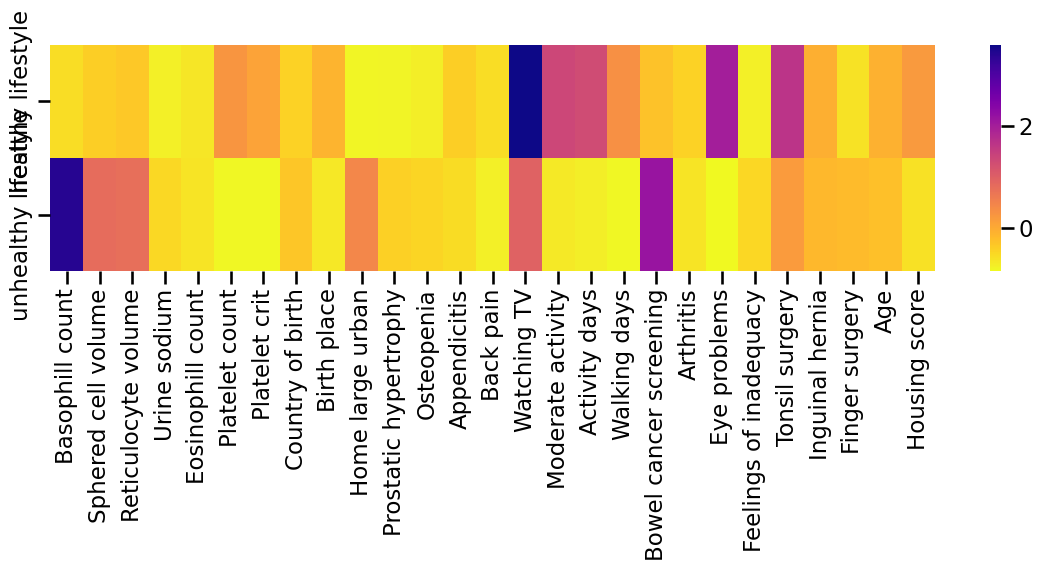

2025-02-01 17:26:16.070512


In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm


# Load the provided data file
file_path = 'APP1.Fig2.D.hotplot.z_score_data.pvalue.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to understand its structure
df.head()
# Extract the columns related to healthy and unhealthy lifestyles
lifestyle_data = df[['Polarized basophil COPD', 'Middle basophil COPD']]

# Flatten the data to calculate the overall mean and standard deviation for z-score calculation
flattened_data = lifestyle_data.values.flatten()

# Calculate the mean and standard deviation of the flattened data
mean = np.mean(flattened_data)
std_dev = np.std(flattened_data)

# Calculate z-scores for the flattened data
z_scores = (flattened_data - mean) / std_dev

# Reshape the z-scores back to the original shape of the lifestyle_data
z_scores_reshaped = z_scores.reshape(lifestyle_data.shape)

# Replace the original data with the z-scores
z_score_df = pd.DataFrame(z_scores_reshaped, columns=['healthy lifestyle', 'unhealthy lifestyle'])

# Add the conditions column back to the DataFrame
z_score_df.insert(0, 'conditions', df['conditions'])

# Plot the heatmap of the z-scores
plt.figure(figsize=(12, 6))
# Use the reversed colormap by adding "_r"
sns.heatmap(z_score_df.set_index('conditions').T, annot=False, cmap=cm.plasma_r, fmt=".2f", cbar=True)
plt.tight_layout()
plt.xlabel('')
plt.savefig('APP1.Panel_D.COPD_subtypes_features.pvalue.svg', dpi=300, bbox_inches='tight')
plt.show()



import datetime

# 获取当前时间
current_time = datetime.datetime.now()

# 打印当前时间
print(current_time)

